In [5]:
pip install osmnx geopandas requests descartes contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 20.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 19.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.7 which is incompatible.
dataprep 0.4.1 requires pandas<2.0,>=1.1, but you have pandas 2.2.3 which is incompatible.

[noti

In [6]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from tqdm.auto import tqdm
import shapely.speedups
shapely.speedups.enable() 
import warnings
warnings.filterwarnings('ignore')
from matplotlib.patches import PathPatch
from matplotlib.path import Path


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_87217/736540332.py:11: DeprecationWarning: This function has no longer any effect, and will be removed in a future release. Starting with Shapely 2.0, equivalent speedups are always available
  shapely.speedups.enable()


In [7]:
PLACE_NAME = 'Florence, Italy'
name = 'Florence'
grid_size = 500

epsg:4326
EPSG:32632


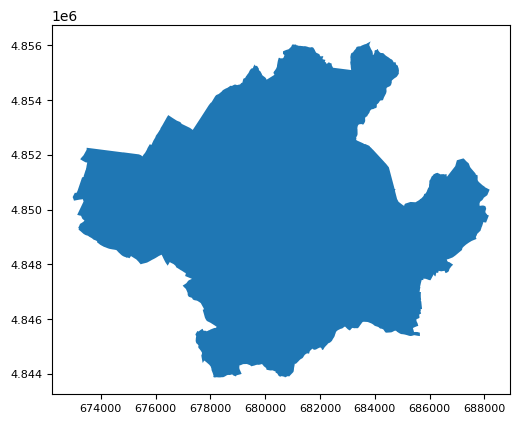

<class 'shapely.geometry.polygon.Polygon'>


In [8]:
city = ox.geocode_to_gdf(PLACE_NAME)
print(city.crs)
# changing CRS for grid division
city = ox.project_gdf(city) 
print(city.crs)

# Plot and store the axis object
ax = city.plot()

# Customize the font size of the tick labels on the axes
ax.tick_params(axis='both', which='major', labelsize=8)

# Display the plot
plt.show()

# Print the type of geometry for your information
geometry = city['geometry'].iloc[0]
print(type(geometry))

In [9]:
#save geometry
city.to_file(f"D:/charging_stations/task2/map/{name}.shp")

DataLayerError: Failed to create file D:/charging_stations/task2/map/Florence.shp: No such file or directory

Division into grid

In [10]:
geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=grid_size) #500 Meter grid
print(type(geometry_cut))
polylist = [poly for poly in geometry_cut.geoms]

<class 'shapely.geometry.multipolygon.MultiPolygon'>


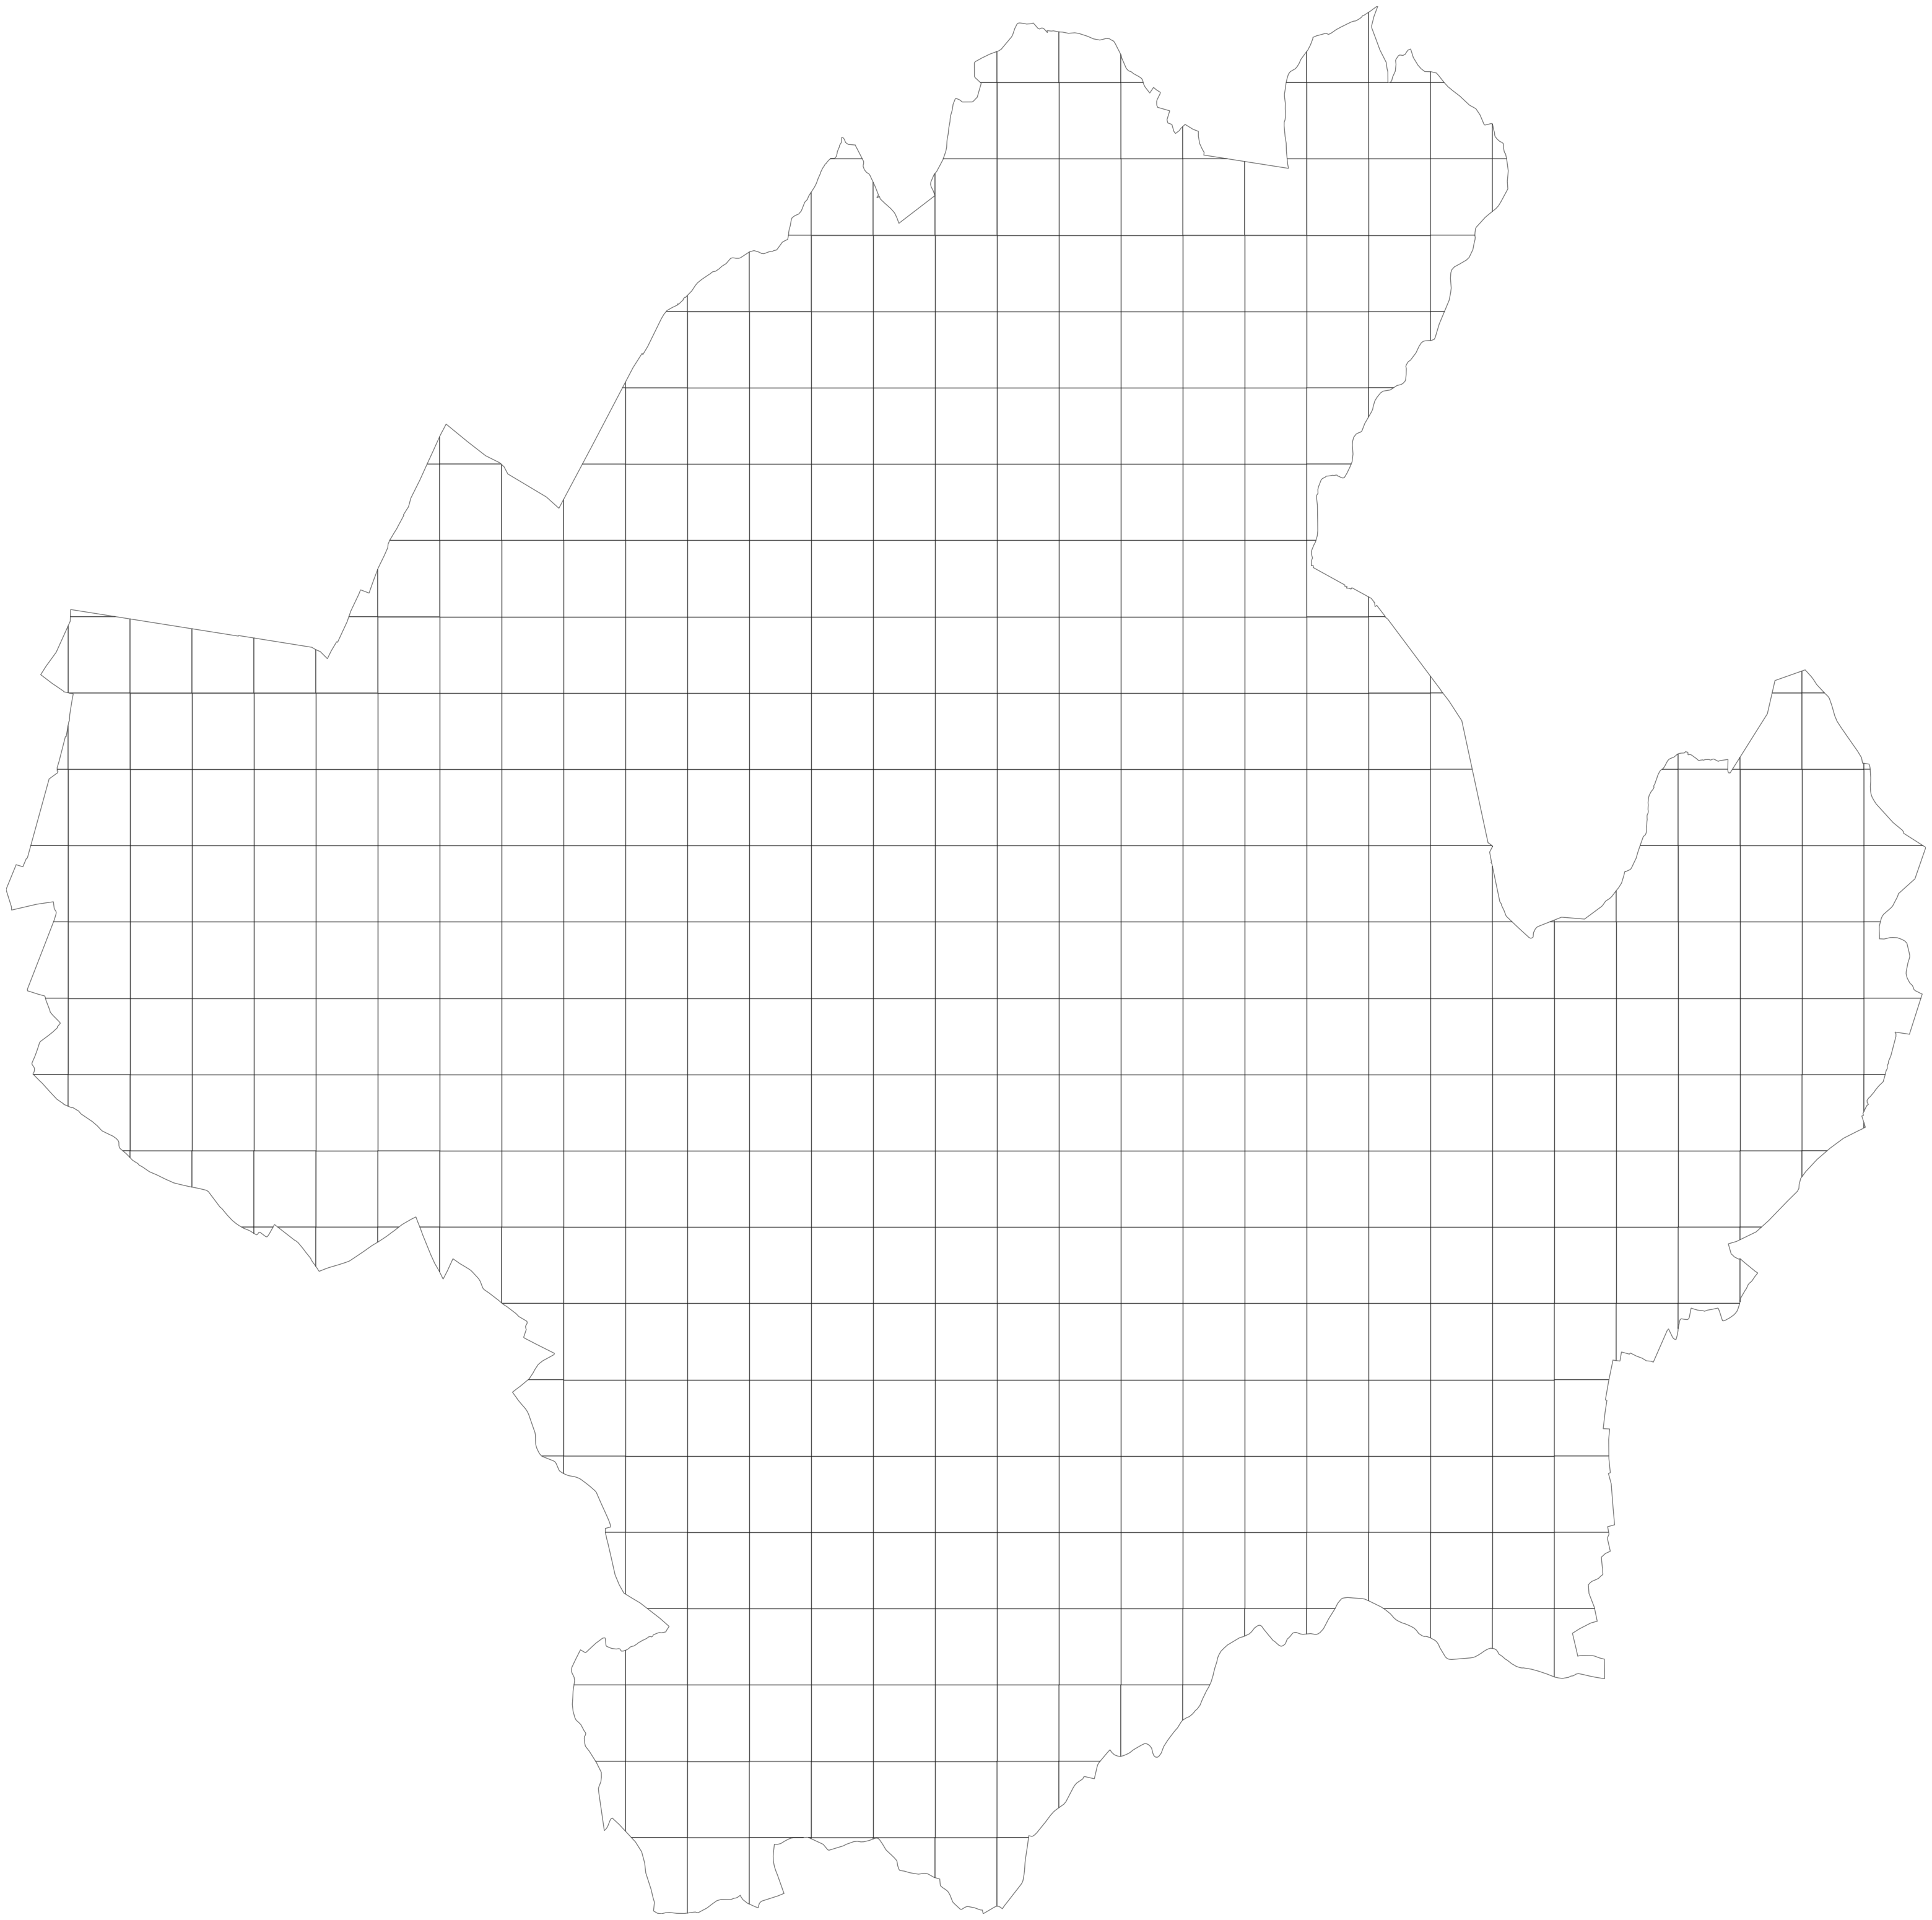

In [11]:
import shapely.geometry as sg
polylist = [poly for poly in geometry_cut.geoms]
# plot city
west, south, east, north = city.unary_union.bounds

# Manual patch creation
fig, ax = plt.subplots(figsize=(40, 40))
for polygon in geometry_cut.geoms:
    if isinstance(polygon, sg.Polygon) and not polygon.is_empty:
        verts = np.array(polygon.exterior.coords)
        codes = np.full(len(verts), Path.LINETO)
        codes[0] = Path.MOVETO
        codes[-1] = Path.CLOSEPOLY
        path = Path(verts, codes)
        patch = PathPatch(path, facecolor='white', edgecolor='black', alpha=0.5)
        ax.add_patch(patch)

ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [12]:
city_polyframe = gpd.GeoDataFrame(geometry=polylist)
city_polyframe.crs = city.crs
print(city_polyframe.crs)
city_polyframe.head()

EPSG:32632


geometry
0  POLYGON ((672972.426 4850455.755, 672972.694 4...
1  POLYGON ((673167.509 4850742.43, 673312.806 48...
2  POLYGON ((673376.832 4851233.127, 673376.568 4...
3  POLYGON ((673463.493 4850251.734, 673463.493 4...
4  POLYGON ((673463.493 4849761.037, 673463.493 4...

(5423117.721175897, 5440014.925075844)

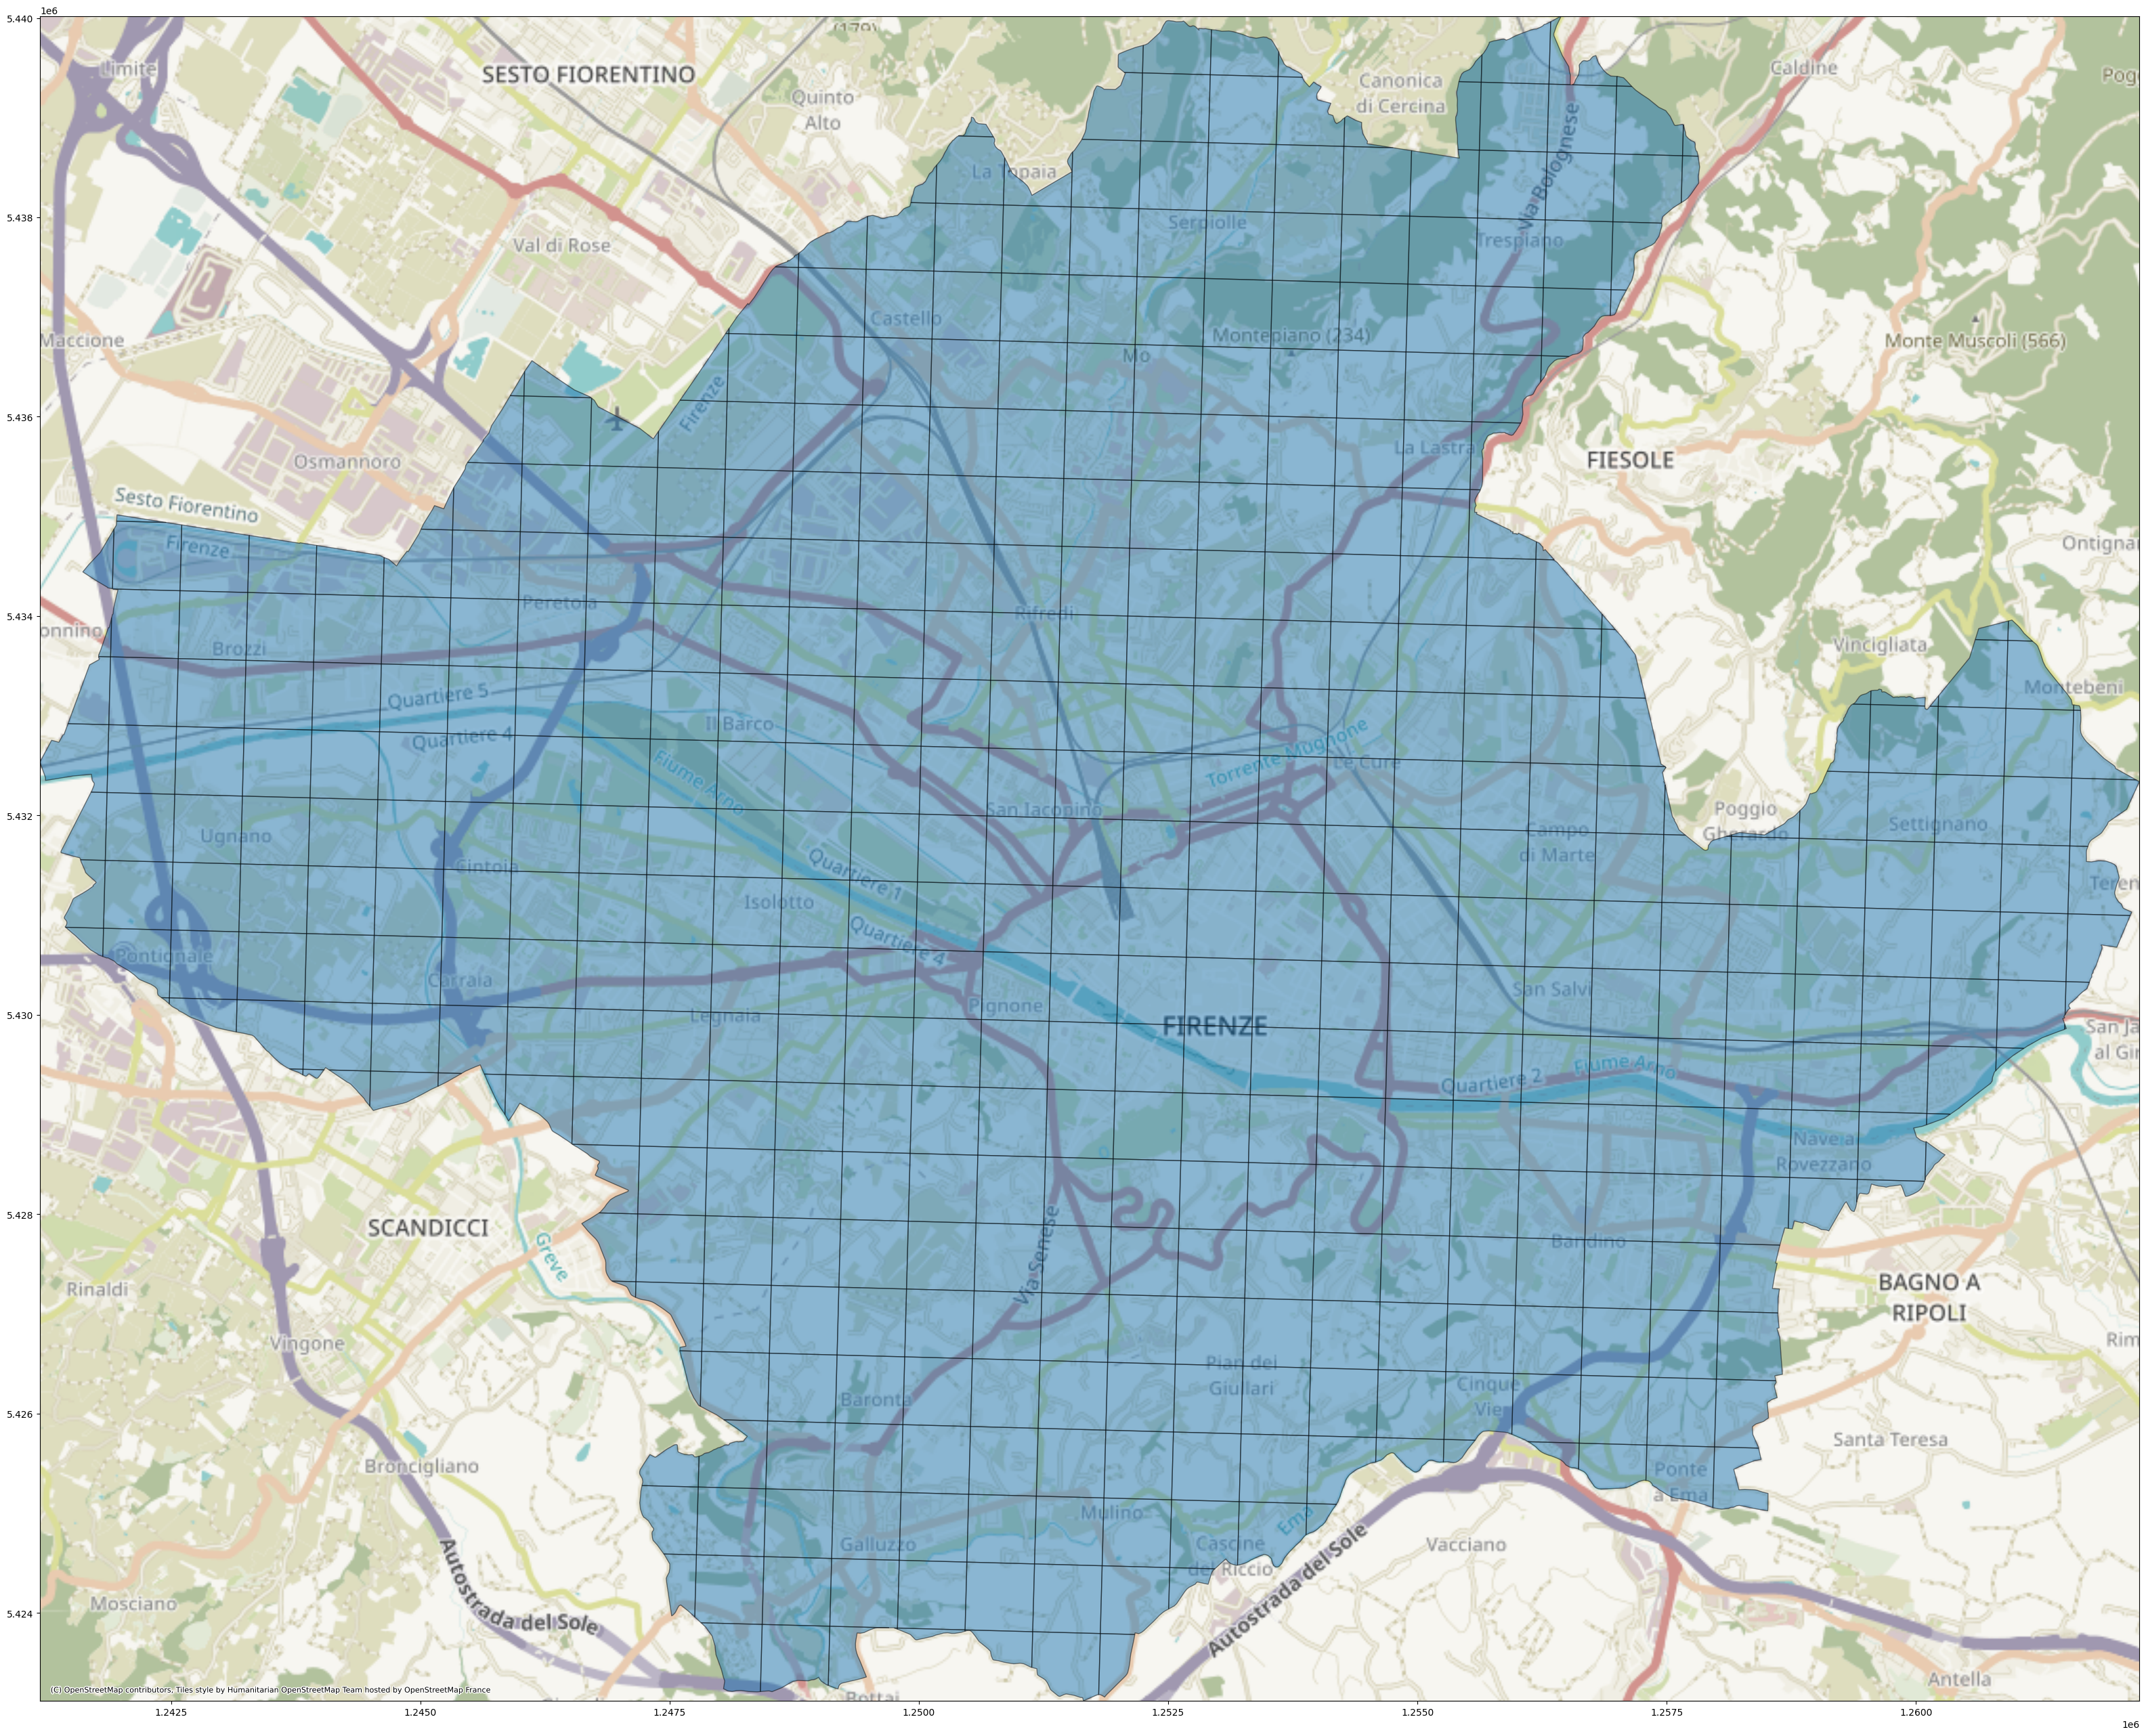

In [13]:
import contextily as ctx
# ctx uses epsg:3857ax = city.plot()
polyframe_3857 = city_polyframe.to_crs(epsg=3857)
west, south, east, north = polyframe_3857.unary_union.bounds

ax = polyframe_3857.plot(figsize=(40,40), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=13)
ax.set_xlim(west, east)
ax.set_ylim(south, north)